Epoch 1/20
Found 167 images belonging to 1 classes.
Found 640 images belonging to 1 classes.
Found 167 images belonging to 1 classes.
Found 640 images belonging to 1 classes.
8/8 [==============================] - 50s 6s/step - loss: 0.4173 - accuracy: 0.4428 - precision: 0.0023 - recall: 0.6064 - tp: 40452.0000 - fp: 17473392.0000 - iou: 0.4997 - dice_coef: 0.5434 - val_loss: 0.4552 - val_accuracy: 0.3869 - val_precision: 0.0017 - val_recall: 0.6172 - val_tp: 8684.0000 - val_fp: 5027577.0000 - val_iou: 0.4996 - val_dice_coef: 0.5464

Epoch 00001: val_loss improved from inf to 0.45524, saving model to unet.hdf5
Epoch 2/20
8/8 [==============================] - 42s 5s/step - loss: 0.2961 - accuracy: 0.5785 - precision: 0.0019 - recall: 0.3910 - tp: 25573.0000 - fp: 13200766.0000 - iou: 0.4997 - dice_coef: 0.5928 - val_loss: 0.4415 - val_accuracy: 0.4759 - val_precision: 0.0018 - val_recall: 0.5415 - val_tp: 7619.0000 - val_fp: 4295786.0000 - val_iou: 0.4996 - val_dice_coef: 0.5586

Epoc

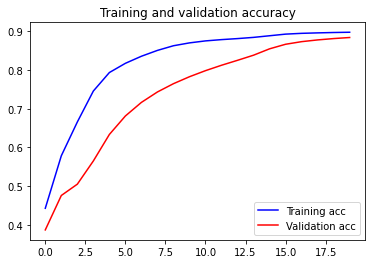

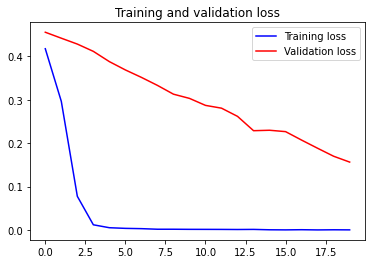

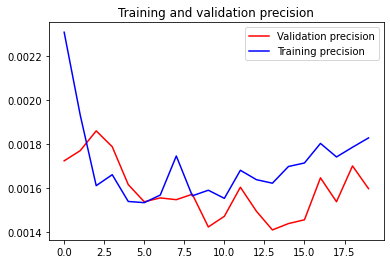

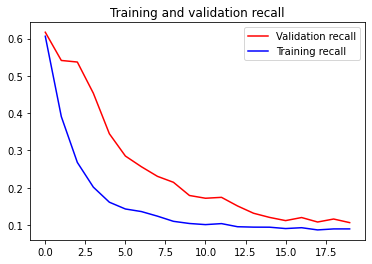

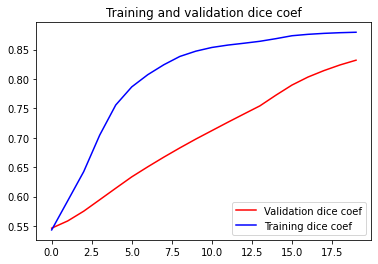

Found 335 images belonging to 1 classes.
Found 335 images belonging to 1 classes.
335/335 [==============================] - 19s 57ms/step
Loss: 0.15068069100379944
Accuracy: 0.885910153388977
Precision: 0.0018184806685894728
Recall: 0.11265818774700165
TP: 3374.0
FP: 1852021.0
[0.15068069100379944, 0.885910153388977, 0.0018184806685894728, 0.11265818774700165, 3374.0, 1852021.0, 0.49958381056785583, 0.8360961675643921]


In [0]:
import random as rn
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers.merge import add, concatenate
from keras.layers import Conv2D, Conv2DTranspose, Dropout, Input, UpSampling2D, MaxPooling2D, Concatenate, BatchNormalization
from keras.models import Model
from keras.metrics import Accuracy, BinaryAccuracy, Precision, Recall, AUC, TruePositives, FalsePositives, MeanIoU, TrueNegatives, FalseNegatives
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras import backend as K
import matplotlib.pyplot as plt

# Lesion being analysed: 'globules' or 'streaks'
LESION = 'streaks'

def obtain_train_generator():
  SEED = 42
  # ImageDataGenerator used to obtain the training set with data augmentation
  train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,           # data augmentation - rotation
    width_shift_range=0.2,       # data augmentation - horizontal shift
    height_shift_range=0.2,      # data augmentation - vertical shift
    horizontal_flip=True,        # data augmentation - flip image
    zoom_range=0.2,              # data augmentation - zoom
    brightness_range=[0.8,1.2]   # data augmentation - brightness
  )
  batchsize = 80
  train_generator = train_datagen.flow_from_directory(
    directory="/content/Dataset/training",
    classes = ['ISBI2016_ISIC_Part2B_Training_Data'],
    target_size=(128, 128),
    batch_size=batchsize,
    class_mode = None,
    seed=SEED
  )

  # obtain masks according to the lesion specified in LESION
  masks_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    brightness_range=[0.8,1.2]
  )
  masks_generator = masks_datagen.flow_from_directory(
    directory="/content/Dataset/training/ISBI2016_ISIC_Part2B_Training_GroundTruth",
    classes = [LESION],
    target_size=(128, 128),
    batch_size=batchsize,
    class_mode = None,
    seed=SEED
  )
  train_generator = zip(train_generator, masks_generator)
  
  # addition of class weights, since the data set is so unbalanced
  sample_weight = np.zeros((batchsize, 128))
  sample_weight[:, 0] = 1
  sample_weight[:, 1] = 90
  for (img, mask) in train_generator:
    yield (img, mask, sample_weight)

def obtain_validation_generator():
  # obtain validation images
  valid_datagen = ImageDataGenerator(
    rescale=1./255
  )
  batchsize = 80
  valid_generator = valid_datagen.flow_from_directory(
    directory="/content/Dataset/validation",
    classes = ['data'],
    target_size=(128, 128),
    batch_size=batchsize,
    class_mode = None
  )

  # obtain validation masks
  masks_datagen = ImageDataGenerator(
    rescale=1./255
  )
  masks_generator = masks_datagen.flow_from_directory(
    directory="/content/Dataset/validation/groundtruth",
    classes = [LESION],
    target_size=(128, 128),
    batch_size=batchsize,
    class_mode = None
  )
  valid_generator = zip(valid_generator, masks_generator)
  for (img, mask) in valid_generator:
    yield (img, mask)

def obtain_test_generator():
  # obtain test images
  test_datagen = ImageDataGenerator(
    rescale=1./255
  )
  batchsize = 1
  test_generator = test_datagen.flow_from_directory(
    directory="/content/Dataset/test",
    classes = ['ISBI2016_ISIC_Part2B_Test_Data'],
    target_size=(128, 128),
    batch_size=batchsize,
    class_mode = None
  )

  # obtain test masks
  masks_datagen = ImageDataGenerator(
    rescale=1./255
  )
  masks_generator = masks_datagen.flow_from_directory(
    directory="/content/Dataset/test/ISBI2016_ISIC_Part2B_Test_GroundTruth",
    classes = [LESION],
    target_size=(128, 128),
    batch_size=batchsize,
    class_mode = None,
    shuffle=False
  )
  test_generator = zip(test_generator, masks_generator)
  for (img, mask) in test_generator:
    yield (img, mask)

def obtain_test_generator_without_masks():
  # obtain test images
  test_datagen = ImageDataGenerator(
    rescale=1./255
  )
  batchsize = 1
  test_generator = test_datagen.flow_from_directory(
    directory="/content/Dataset/test",
    classes = ['ISBI2016_ISIC_Part2B_Test_Data'],
    target_size=(128, 128),
    batch_size=batchsize,
    class_mode = None,
    shuffle=False
  )
  return test_generator

# Dice loss function
def dice_loss(y_true, y_pred):
  return 1-dice_coef(y_true, y_pred)

# Dice coefficients function
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
  return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

# Jaccard loss function
def jaccard_loss(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
  sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
  jac = (intersection + smooth) / (sum_ - intersection + smooth)
  return (1 - jac) * smooth

# Weighted loss function
def weighted_loss(y_true, y_pred):
  pos_weight = 0.01
  loss = tf.nn.weighted_cross_entropy_with_logits(
    y_true, y_pred, pos_weight, name=None
  )
  return loss

# Creation of UNET model
def create_unet_model():
  inputs = Input(shape=(128, 128, 3))
  x1 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  x1 = BatchNormalization()(x1)
  x1 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x1)
  x1 = BatchNormalization()(x1)
  x2 = MaxPooling2D(pool_size=(2, 2))(x1)
  x2 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x2)
  x2 = BatchNormalization()(x2)
  x2 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x2)
  x2 = BatchNormalization()(x2)
  x3 = MaxPooling2D(pool_size=(2, 2))(x2)
  x3 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x3)
  x3 = BatchNormalization()(x3)
  x3 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x3)
  x3 = BatchNormalization()(x3)
  x4 = MaxPooling2D(pool_size=(2, 2))(x3)
  x4 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x4)
  x4 = BatchNormalization()(x4)
  x4 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x4)
  x4 = BatchNormalization()(x4)
  x5 = MaxPooling2D(pool_size=(2, 2))(x4)
  x5 = Conv2D(1024, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x5)
  x5 = Conv2D(1024, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x5)
  x6 = Conv2DTranspose(512, (3, 3), strides = (2, 2), padding = 'same')(x5)
  x6 = Concatenate()([x4, x6])
  x6 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x6)
  x6 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x6)
  x6 = Conv2DTranspose(256, (3, 3), strides = (2, 2), padding = 'same')(x6)
  x6 = Concatenate()([x3, x6])
  x6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x6)
  x6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x6)
  x6 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(x6)
  x6 = Concatenate()([x2, x6])
  x6 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x6)
  x6 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x6)
  x6 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(x6)
  x6 = Concatenate()([x1, x6])
  x6 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x6)
  x6 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x6)
  x6 = Conv2D(3, (1, 1), activation = 'sigmoid')(x6)

  model = Model(inputs, x6)

  metrics = [
    BinaryAccuracy(name='accuracy'),
    Precision(name='precision'),
    Recall(name='recall'),
    TruePositives(name='tp'),
    FalsePositives(name='fp'),
    MeanIoU(name='iou', num_classes=2),
    dice_coef
  ]
  
  # Model compilation with Dice loss function
  model.compile(
      optimizer=Adam(lr=3e-5),
      loss=dice_loss,
      metrics=metrics,
      sample_weight_mode='temporal'
  )
  #tf.keras.utils.plot_model(model, show_shapes=True)
  #model.summary()
  
  return model

model = create_unet_model()

EPOCHS = 20
checkpoint = ModelCheckpoint('unet.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
train_generator = obtain_train_generator()
validation_generator = obtain_validation_generator()

# Train model
model_history = model.fit_generator(
    train_generator, epochs=EPOCHS,
    steps_per_epoch=8,
    validation_steps=3,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping],
    verbose=1,
    use_multiprocessing=False,
    max_queue_size=10,   
    workers=1
)

# Show train results
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
val_precision = model_history.history['val_precision']
precision = model_history.history['precision']
recall = model_history.history['recall']
val_recall = model_history.history['val_recall']
dice_coef = model_history.history['dice_coef']
val_dice_coef = model_history.history['val_dice_coef']

epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, val_precision, 'r', label='Validation precision')
plt.plot(epochs, precision, 'b', label='Training precision')
plt.title('Training and validation precision')
plt.legend()
plt.figure()
plt.plot(epochs, val_recall, 'r', label='Validation recall')
plt.plot(epochs, recall, 'b', label='Training recall')
plt.title('Training and validation recall')
plt.legend()
plt.figure()
plt.plot(epochs, val_dice_coef, 'r', label='Validation dice coef')
plt.plot(epochs, dice_coef, 'b', label='Training dice coef')
plt.title('Training and validation dice coef')
plt.legend()

plt.show()

# Evaluate trained model on test dataset
test_generator = obtain_test_generator()
results = model.evaluate(test_generator, steps=335)
print("Loss: " + str(results[0]))
print("Accuracy: " + str(results[1]))
print("Precision: " + str(results[2]))
print("Recall: " + str(results[3]))
print("TP: " + str(results[4]))
print("FP: " + str(results[5]))
print(results)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r /content/drive/My\ Drive/Data/task3 /content/Dataset